# Testing notebook

This notebook contains all the tools you need to test out the `BayesianRatingSystems` package!

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import plotly.graph_objects as go
import plotly.express as px

import dash
from jupyter_dash import JupyterDash
from dash import Dash, html, dcc, Input, Output

import pandas as pd
import numpy as np
from market_simulation import BayesianRatingsManager
import copy
import pyarrow

from sklearn.model_selection import train_test_split

In [3]:
sim = BayesianRatingsManager()

# put in your own data below...

example_df = pd.read_csv('tripadvisor-numeric.dat', on_bad_lines='skip')
# specify product column and ratings column here
sim.add_data(example_df, product_col='Hotel ID', ratings_col='Overall Rating', rng=1729)
example_df.head()[['Hotel ID', 'User ID', 'Overall Rating']]

auto-detecting ratings data style.
detected ratings type: discrete


,Hotel ID,User ID,Overall Rating
0,100504,selizabethm,5
1,100504,IndieLady,4
2,100504,Hilobb,4
3,100504,Chiantigirl24,5
4,100504,hothearted,5


In [4]:
# if you have more than 20 products, upsampling the dataset down to 20 is recommended
sim.upsample(20)

upsampling task down to 20 products complete


In [5]:
sim.fit_prior()

prior fit complete!
prior type: Dirichlet, with weights [0 1 2 3 4 5]


array([0.74829848, 1.12643731, 1.55924861, 2.12635119, 4.8970427 ,
       4.39947131])

In [9]:
sim.clear_outputs()
sim.run_simulations(rng=1729) # add a coverage warning if upsampling is needed

outputs cleared.
defaulting to 200000 number of timesteps


Simulation progress: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:58<00:00, 10.65s/it][Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  3.0min finished
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  3.0min remaining:    0.0s
Simulation progress: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:58<00:00, 29.67s/it]

Simulations complete.


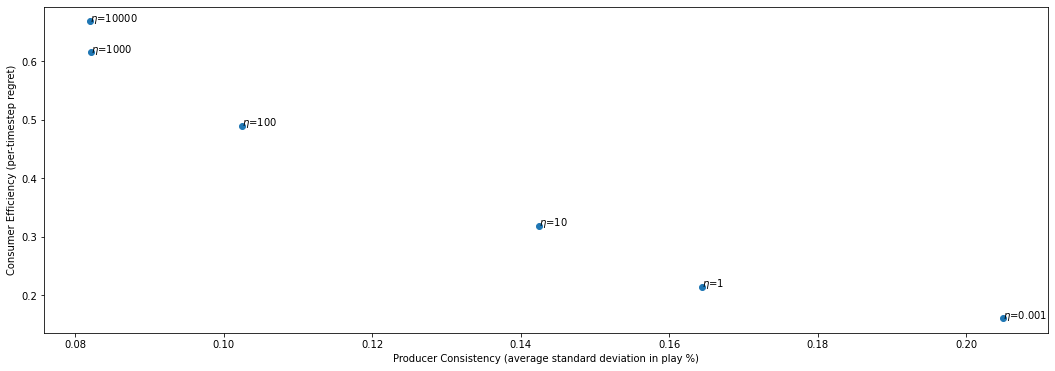

<Figure size 432x288 with 0 Axes>

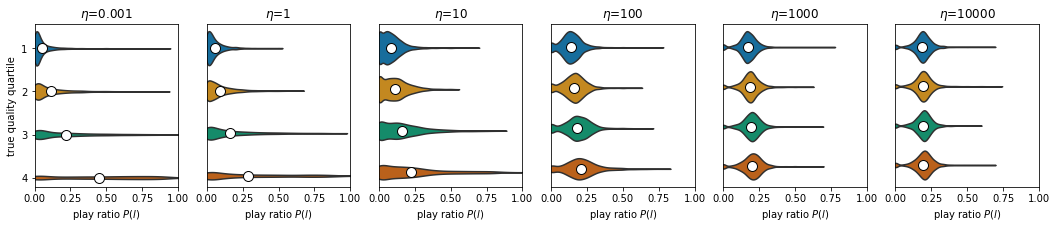

<Figure size 432x288 with 0 Axes>

In [15]:
sim.summary()

In [17]:
sim.get_simulation_level_interactive_view(notebook=True)

eta value


In [18]:
sim.get_product_level_interactive_view(notebook=True)

## scratch

In [ ]:
weighting_data = []
data_weights = sim._data_cleaner.weights
columns = ['eta', 'prod'] + ['c'+str(item) for item in list(data_weights)]

data = sim._get_interactive_data()[['eta', 'prod', 'true quality']].drop_duplicates()
data2 = sim.get_simulation_data()

for datadict in data2:
    for (k1, k2) in datadict:
        agg_ratings = np.zeros(len(data_weights))
        for lifespan in datadict[(k1,k2)]:
            agg_ratings += lifespan[-1] - lifespan[0]
        d = {k:v for k, v in zip(columns, [[k2], [k1]] + [[item] for item in list(np.round(agg_ratings))])}

        weighting_data.append(pd.DataFrame(d))
    
weighting_data = pd.concat(weighting_data)
        
data = data.merge(weighting_data, on=['eta', 'prod'])
data = pd.wide_to_long(data, stubnames='c', i=['eta', 'prod', 'true quality'], j='rating').reset_index()

In [ ]:
mask = (data['eta'].isin(sorted(['0.001', '1']))) & (data['prod'].isin(sorted([310251, 252969])))

In [ ]:
fig = px.bar(data[mask], x='rating', y='c', color='eta', barmode='group', text='prod')

In [ ]:
eta_dropdown_options = sorted(list(data['eta'].unique()))
prod_dropdown_options = sorted(list(data['prod'].unique()))

In [ ]:
cdmap = {k: v for k, v in zip(list(data['eta'].unique()),
                              px.colors.qualitative.Alphabet[:len(data['eta'].unique())])}

In [ ]:
cdmap

In [ ]:
app = JupyterDash()

app.layout = html.Div([
    dcc.Graph(figure=fig, id='product_level_view'),
    html.Div([
        "etas",
        dcc.Dropdown(
            eta_dropdown_options,
            [eta_dropdown_options[0]],
            id="eta_dropdown",
            multi=True
        )
    ]),
    html.Div([
        "products",
        dcc.Dropdown(
            prod_dropdown_options,
            [prod_dropdown_options[0]],
            id="prod_dropdown",
            multi=True
        ),
    ]),
])

@app.callback(
    Output('product_level_view', 'figure'),
    Input('eta_dropdown', 'value'),
    Input('prod_dropdown', 'value'))
def update_figure(value_etas, value_products):
    m = (data['eta'].isin(sorted(value_etas))) & (
        data['prod'].isin(sorted(value_products)))

    f = px.bar(data[m],
               x='rating',
               y='c',
               color='eta',
               barmode='group',
               text='prod',
               color_discrete_map=cdmap)

    return f

app.run_server(debug=True, use_reloader=False, mode='inline')

In [ ]:
p = px.scatter(pd.DataFrame({'inconsistency': data[0], 'regret': data[1], 'eta': data[2]}),
           x = 'inconsistency',
           y = 'regret',
           color = 'eta')

In [ ]:
p.show()

In [ ]:
df = sim._get_simulation_level_interactive_data()
df['rounded true quality'] = df['true quality'].round()
df['rounded play ratio'] = (df['play ratio']*20).round()/20
df = df.groupby(['eta', 'rounded true quality', 'rounded play ratio']).count().reset_index()[['eta', 'rounded true quality', 'rounded play ratio', 'play ratio']]

In [ ]:
df.head()

In [ ]:
px.bar(df[df['eta']=='0.001'], x='rounded play ratio', y='play ratio', animation_frame='rounded true quality')

In [ ]:
eta_list = list(df['eta'].unique())
dfs_to_plot = {}

for eta in eta_list:
    df_to_plot = df[df['eta']==eta]
    to_add = []

    for val in list(df['rounded play ratio'].unique()):
        for rtq in list(df_to_plot['rounded true quality'].unique()):
            if val not in df_to_plot[df_to_plot['rounded true quality']==rtq]['rounded play ratio']:
                temp_df = pd.DataFrame({'eta': eta, 
                                        'rounded true quality': rtq, 
                                        'rounded play ratio': val, 
                                        'play ratio': 0}, index=[0])
                to_add.append(temp_df)

    df_to_plot = pd.concat(to_add + [df_to_plot])
    
    dfs_to_plot[eta] = df_to_plot
    
slider_min, slider_max = df['rounded true quality'].min(), df['rounded true quality'].max()

In [ ]:
# df_to_plot=copy.deepcopy(dfs_to_plot[eta_list[0]])
# df_to_plot = df_to_plot.sort_values('rounded true quality')
# df_to_plot['rounded true quality'] = df_to_plot['rounded true quality'].astype(str)

# cdmap = {k:v for k, v in zip(list(df_to_plot['rounded true quality'].unique()),
#                      px.colors.qualitative.Alphabet[:len(df_to_plot['rounded true quality'].unique())])}

# fig = px.bar(df_to_plot, 
#                 x='rounded play ratio', 
#                 y='play ratio', 
#                 color = 'rounded true quality',
#                 color_discrete_map=copy.deepcopy(cdmap))

# fig.update_xaxes(title='play ratio')
# fig.update_yaxes(title='count')
# fig.update_layout(barmode='stack')
# app = JupyterDash()
# app.layout = html.Div([
#     dcc.Dropdown(eta_list, eta_list[0], id='eta_dropdown'),
#     dcc.Graph(figure=fig,id='prior_level_view'),
#     dcc.RangeSlider(slider_min, slider_max, 1, value=[slider_min, slider_max],id='rtq_slider')
# ])

# @app.callback(
#     Output('prior_level_view', 'figure'),
#     Input('eta_dropdown', 'value'),
#     Input('rtq_slider', 'value'))
# def update_figure(value_dropdown, value_slider):
    
#     df_to_plot=copy.deepcopy(dfs_to_plot[value_dropdown])
#     df_to_plot = df_to_plot[df_to_plot['rounded true quality'].between(value_slider[0], value_slider[1])]
#     df_to_plot = df_to_plot.sort_values('rounded true quality')
#     df_to_plot['rounded true quality'] = df_to_plot['rounded true quality'].astype(str)

#     fig = px.bar(df_to_plot, 
#                     x='rounded play ratio', 
#                     y='play ratio', 
#                     color = 'rounded true quality',
#                     color_discrete_map=copy.deepcopy(cdmap))
    

#     return fig


# print('eta value')

# app.run_server(debug=True, use_reloader=False, mode='inline')

In [ ]:
{k:v for k, v in zip(list(df['rounded true quality'].unique()),
                     px.colors.qualitative.Alphabet[:len(df['rounded true quality'].unique())])}

In [ ]:
# # emergency valve to kill the dash server

# import os
# import signal
# os.kill(os.getpid(), signal.SIGTERM)

In [ ]:
px.colors.qualitative.Alphabet